In [ ]:
import numpy as np
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


def unitary(phi, omega, theta):
    a1 = np.exp(-1j*(phi + omega)/2)*np.cos(theta/2)
    a2 = -np.exp(1j*(phi - omega)/2) *np.sin(theta/2)
    a3 = np.exp(-1j*(phi - omega)/2) * np.sin(theta/2)
    a4 = np.exp(1j*(phi + omega)/2) * np.cos(theta/2)
    U = np.array([[a1, a2], [a3, a4]])
    return U
    
# define n-tangle

def n_tangle(psi, N):
    # <psi| sigma_y^{tensor n} |psi*>
    
    # how many qubits: N
    assert 2**N == len(psi), "state vector length must be 2^n"
    # n tangle of odd qubits is 0
    if N % 2 == 1:
        return 0.0

    # single-qubit sigma_y
    sy = np.array([[0, -1j],[1j, 0]])

    # build sigma_y^{⊗N}
    Sy = sy
    for _ in range(N-1):
        Sy = np.kron(Sy, sy)

    # spin-flipped state
    psi_star = np.conjugate(psi)
    psi_tilde = Sy.dot(psi_star)

    z = np.dot(psi, psi_tilde)
    z_conj = np.conjugate(z)
    # return sqrt (zz*)
    return np.sqrt(z*z_conj)

# in order to estimate L^tau, we must take the maximum of tau bar_beta over beta local... what does this mean?
# beta is LOCAL: implies each qubit has its own basis?

# get arg max_U tau bar _U (GHZ) = H

In [6]:
# code to compute L^tau: maximize over unitaries

# input: vector to measure, d_A, d_B, number of samples
# output: max n-tangle, angles of the unitary which achieve this.

def L_tau(psi, d_A, d_B, num_samples=20):
    # psi is the vector (e.g. |GHZ>), d_A is the dimension of system A, d_B is the dimension of system B
    max_tangle = -np.inf # store as lowest value
    best_angles = None # empty for now
    # generate inputs for unitaries
    thetas = np.linspace(0, 2*np.pi, num_samples, endpoint=False)
    phis = np.linspace(0, 2*np.pi, num_samples, endpoint=False)
    omegas = np.linspace(0, 2*np.pi, num_samples, endpoint=False)

    # go through inputs and get measurement basis vector
    for theta in thetas:
        for phi in phis:
            for omega in omegas:
                U = unitary(phi, omega, theta)
                # multiply U by |0> OR get first col of U
                m = U[:,0] # measurement vector: 2 by 1
                m2 = U[:1,]

                # build measurement projector <m| \tensor I_B
                M = np.kron(m.conj().T, np.eye(2**(d_B)))
                M2 = np.kron(m2.conj().T, np.eye(2**(d_B)))

                # measure psi
                post_U = M @ psi
                # norm is the probability of getting outcome |m>
                norm = np.linalg.norm(post_U)
                
                post_U2 = M2 @ psi
                norm2 = np.linalg.norm(post_U2)
                # if probability is numerically zero, then dividing is meaningless
                if (norm < 1e-12 or norm2 < 1e-12):
                    continue

                psi_B = post_U / norm
                psi_B2 = post_U2 / norm2

                # compute n-tangle
                t = n_tangle(psi_B, (d_B))
                t2 = n_tangle(psi_B2, (d_B))
                # respective probabilities
                p = norm**2
                p2 = norm2**2

                L_tau = p*t + p2*t2

                if (L_tau > max_tangle):
                    max_tangle = L_tau
                    best_angles = (theta, phi, omega)


    return max_tangle, best_angles






In [7]:
# test on GHZ
psi_GHZ = np.zeros(8, dtype=complex)
psi_GHZ[0] = 1/np.sqrt(2)
psi_GHZ[7] = 1/np.sqrt(2)

m = np.array([1,0])
m2 = np.array([0,1])
M = np.kron(m.conj().T, np.eye(4))
M2 = np.kron(m2.conj().T, np.eye(4))
postone = M @ psi_GHZ
posttwo = M2 @ psi_GHZ
# postone = np.kron(M, np.eye(8) @ psi_GHZ)
# posttwo= np.kron(M2, np.eye(8) @ psi_GHZ)


norm = np.linalg.norm(postone)
norm2 = np.linalg.norm(posttwo)

psi_B1 = postone / norm
psi_B2 = posttwo/ norm2

print(f"post |0> : {psi_B1}, post |1>: {psi_B2}")



# # compute
# L_ghz, (theta_ghz, phi_ghz, omega_ghz), psi_B = L_tau(psi_GHZ, 1, 2, 50)




# print(f"L^τ(GHZ) ≈ {L_ghz:.6f} at θ={theta_ghz:.3f}, φ={phi_ghz:.3f}, w={omega_ghz:.3f}")
# print(f"psi_B = {psi_B}")


post |0> : [1.+0.j 0.+0.j 0.+0.j 0.+0.j], post |1>: [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


In [51]:
# compute
L_ghz, (theta_ghz, phi_ghz, omega_ghz) = L_tau(psi_GHZ, 1, 2, 100)
U = unitary(phi_ghz, omega_ghz, theta_ghz)

print(f"L^τ(GHZ) ≈ {L_ghz:.6f} at θ={theta_ghz:.3f}, φ={phi_ghz:.3f}, w={omega_ghz:.3f}")
print(f"U = {U}")



L^τ(GHZ) ≈ 1.000000+0.000000j at θ=1.571, φ=0.314, w=0.000
U = [[ 0.69840112-0.11061587j -0.69840112-0.11061587j]
 [ 0.69840112-0.11061587j  0.69840112+0.11061587j]]


In [52]:
U_inv = np.linalg.inv(U)
U_conj_T = U.conj().T

print(f"U inv = {U_inv}")
print(f"U conj transpose = {U_conj_T}")

U inv = [[ 0.69840112+0.11061587j  0.69840112+0.11061587j]
 [-0.69840112+0.11061587j  0.69840112-0.11061587j]]
U conj transpose = [[ 0.69840112+0.11061587j  0.69840112+0.11061587j]
 [-0.69840112+0.11061587j  0.69840112-0.11061587j]]


In [49]:
# using an optimizer instead of brute force:
import numpy as np
from scipy.optimize import minimize

def L_tau_weighted(angles, psi, n_A, n_B):
    d_A = 2**(n_A)
    d_B = 2**(n_B)
    theta, phi, omega = angles
    U = unitary(phi, omega, theta)    
    # the two measurement outcomes:
    m0 = U[:,0]    
    m1 = U[:,1]    
    
    # build projectors ⟨m_i|⊗I
    I_B = np.eye(d_B)
    M0 = np.kron(m0.conj().T, I_B)   
    M1 = np.kron(m1.conj().T, I_B)
    
    # apply and get probabilities + post‐states
    post0 = M0 @ psi
    post1 = M1 @ psi
    p0 = np.vdot(post0, post0).real
    p1 = np.vdot(post1, post1).real
    
    # if either branch is essentially zero, penalize heavily
    if p0 < 1e-12 or p1 < 1e-12:
        return 1e3 + (p0+p1)  # large positive
    
    psi0 = post0 / np.sqrt(p0)
    psi1 = post1 / np.sqrt(p1)
    
    # compute 2-tangles
    t0 = n_tangle(psi0, n_B)
    t1 = n_tangle(psi1, n_B)
    
    # weighted average, negated (since we minimize)
    return -(p0*t0 + p1*t1)

# use optimizer over L_tau
def L_tau_opt(psi, n_A, n_B):
    # initial guess: random angles in [0,2π)
    x0 = np.random.rand(3) * 2*np.pi
    
    # constraints 0 ≤ x[i] ≤ 2π as inequality funs for COBYLA
    cons = []
    for i in range(3):
        cons.append({'type':'ineq', 'fun': lambda x, i=i: x[i]})
        cons.append({'type':'ineq', 'fun': lambda x, i=i: 2*np.pi - x[i]})
    
    res = minimize(
        L_tau_weighted, x0,
        args=(psi, n_A, n_B),
        method='COBYLA',
        constraints=cons,
        options={'maxiter': 500, 'tol':1e-6, 'rhobeg':1.0}
    )
    
    theta_opt, phi_opt, omega_opt = res.x
    max_Ltau = -res.fun
    return max_Ltau, (theta_opt, phi_opt, omega_opt)



In [50]:
# --- Example on GHZ ---
psi_GHZ = np.zeros(8, dtype=complex)
psi_GHZ[0] = 1/np.sqrt(2)
psi_GHZ[7] = 1/np.sqrt(2)


L_val, (thetaGHZ, phiGHZ, omegaGHZ) = L_tau_opt(
    psi_GHZ,
    n_A=1, n_B=2,
)

thetapi = thetaGHZ / np.pi
phipi = phiGHZ / np.pi
U_optimized = unitary(phiGHZ, omegaGHZ, thetaGHZ)
print(f"L^τ(GHZ) ≈ {L_val:.6f} at θ={thetapi:.3f} pi, φ={phipi:.3f} pi, w={omegaGHZ:.3f}")
print(f"U = {U_optimized}")

L^τ(GHZ) ≈ 1.000000 at θ=0.500 pi, φ=1.962 pi, w=3.142
U = [[-0.04264   +0.70581994j -0.04264087-0.70581994j]
 [ 0.04264087-0.70581994j -0.04264   -0.70581994j]]


c:\Users\abbie\miniconda3\envs\qis102\Lib\site-packages\scipy\optimize\_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


In [77]:
# try on haar randoms
from numpy.linalg import qr
def qr_haar(N):
    """Generate a Haar-random matrix using the QR decomposition."""
    # Step 1
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B

    # Step 2
    Q, R = qr(Z)

    # Step 3
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])

    # Step 4
    U = np.dot(Q, Lambda)
    return U[0:,]

# state prep
n_A = 1
n_B = 2
d_A = 2**(n_A)
d_B = 2**(n_B)
U = qr_haar(d_A * d_B)
zero = np.array([1, 0])
zero_tensored = zero
for i in range(n_A + n_B - 1):
    zero_tensored = np.kron(zero, zero_tensored)
psi = U @ zero_tensored
L_val, (theta, phi, omega) = L_tau_opt(psi,n_A, n_B)
U_optimized = unitary(phi, omega, theta)
print(f"L^τ(GHZ) ≈ {L_val:.6f} at θ={theta:.3f} pi, φ={phi:.3f} pi, w={omega:.3f}")
print(f"U = {U_optimized}")

L^τ(GHZ) ≈ 0.360355 at θ=4.267 pi, φ=1.341 pi, w=3.234
U = [[ 0.35033353+0.4021674j -0.49467968+0.6861631j]
 [ 0.49467968+0.6861631j  0.35033353-0.4021674j]]


c:\Users\abbie\miniconda3\envs\qis102\Lib\site-packages\scipy\optimize\_cobyla_py.py:293: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


In [ ]:
# plot averages of L_tau for n_B in (2, 4, 6, 8, 10)
nA = 2
nB_values = list(range(2, 11, 2)) 



In [382]:
# from Pennylaneai:
from mpl_toolkits.mplot3d import Axes3D  # registers the 3D projection
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

# Used the mixed state simulator so we could have the density matrix for this part!
def convert_to_bloch_vector(rho):
    """Convert a density matrix to a Bloch vector."""
   
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]

def bloch_vector(psi):
    psi = psi / np.linalg.norm(psi)
    # your normalized state:
    alpha, beta = psi[0], psi[1]

    # remove global phase
    phase = np.angle(alpha)
    alpha_p = np.abs(alpha)
    beta_p  = beta * np.exp(-1j*phase)

    # spherical angles
    theta = 2*np.arccos(alpha_p)
    phi   = np.angle(beta_p)

    # Bloch coords
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return np.array([x, y, z])

# with this done, let's find out where our "uniformly random" states ended up


def plot_bloch_sphere(bloch_vectors):
    """Plot a Bloch sphere with given Nx3 array of vectors."""
    fig = plt.figure(figsize=(6, 6))
    ax  = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # 1) sphere surface
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0,   np.pi, 30)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(x, y, z, 
                    rstride=4, cstride=4, 
                    color='lightgray', alpha=0.2, linewidth=0)

    # 2) axes arrows
    origins = np.array([[-1.5,0,0], [0,-1.5,0], [0,0,-1.5]])
    directions = np.eye(3)*3
    ax.quiver(origins[:,0], origins[:,1], origins[:,2],
              directions[:,0], directions[:,1], directions[:,2],
              arrow_length_ratio=0.05, color="black", linewidth=0.5)

    # 3) standard basis labels
    ax.text(0, 0, 1.7,  r"$|0>,$",   fontsize=16)
    ax.text(0, 0,-1.9,  r"$|1>,$",   fontsize=16)
    ax.text(1.9, 0, 0,  r"$|+>,$",   fontsize=16)
    ax.text(-1.7,0, 0,  r"$|->,$",   fontsize=16)
    ax.text(0, 1.7,0,  r"$|i+>,$",  fontsize=16)
    ax.text(0,-1.9,0,  r"$|i->,$",  fontsize=16)

    # 4) your Bloch vectors
    bloch_vectors = np.atleast_2d(bloch_vectors)
    ax.scatter(bloch_vectors[:,0],
               bloch_vectors[:,1],
               bloch_vectors[:,2],
               c='#e29d9e', alpha=0.8, s=50)

    # 5) clean up
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)
    ax.set_box_aspect([1,1,1])   # ← the crucial “equal aspect” call

    plt.show()


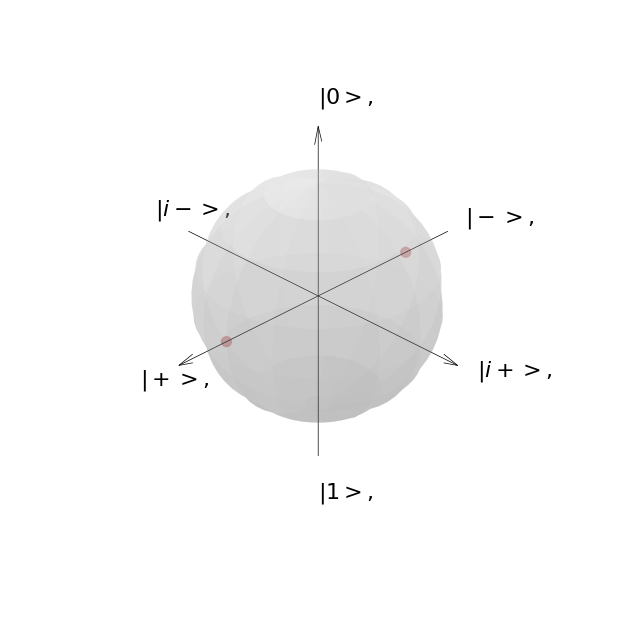

In [417]:
# code to plot vector representation on the bloch sphere:
psi_zero = U_optimized[:,0]

psi_one = U_optimized[:,1]

rho0 = np.outer(psi_zero, psi_zero.conj())
psi_zero_bloch = convert_to_bloch_vector(rho0)

rho1 = np.outer(psi_one, psi_one.conj())
psi_one_bloch = convert_to_bloch_vector(rho1)

to_plot = np.array([psi_zero_bloch, psi_one_bloch])
plot_bloch_sphere(to_plot)
